# Mock data analysis - Assured Allies 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from statsmodels.graphics.factorplots import interaction_plot

pd.options.display.max_columns = 200
pd.options.display.float_format = "{:,.2f}".format

## Create mock data

In [2]:
# control participants

# define constants
N=307
# outcomes
cost_mu = 50000; cost_sigma = 15000
claim_p = .5
# predictors
age_mu = 75; age_sigma = 5
iadl_mu = 4; iadl_sigma = 1
male_p = 0.5; female_p = 0.5;

# generate data
np.random.seed(123)
control_df = pd.DataFrame()
control_df['gender'] = np.random.choice(['male', 'female'], N, p=[male_p, female_p])
control_df['group'] = 'control'
control_df['iadl'] = abs(np.random.normal(loc = iadl_mu, scale = iadl_sigma, size = N).round())
control_df['age'] = abs(np.random.normal(loc = age_mu, scale = age_sigma, size = N).round())
control_df.loc[control_df['age'] < 65, 'age'] = age_mu
control_df['claims'] = np.random.choice([0, 1], N, p=[1-claim_p, claim_p])
control_df['cost_claims'] = abs(np.random.normal(loc = cost_mu, scale = cost_sigma, size = N).round())
control_df.loc[control_df['claims'] == 0, 'cost_claims'] = 0

In [3]:
# Intervention participants

# define constants
N=307
# outcomes
cost_mu = 20000; cost_sigma = 15000
claim_p = .45
# predictors
age_mu = 75; age_sigma = 10
iadl_mu = 3.5; iadl_sigma = 1
male_p = 0.5; female_p = 0.5;

# generate data
np.random.seed(321)
int_df = pd.DataFrame()
int_df['gender'] = np.random.choice(['male', 'female'], N, p=[male_p, female_p])
int_df['group'] = 'intervention'
int_df['iadl'] = abs(np.random.normal(loc = iadl_mu, scale = iadl_sigma, size = N).round())
int_df['age'] = abs(np.random.normal(loc = age_mu, scale = age_sigma, size = N).round())
int_df.loc[control_df['age'] > 65, 'age'] = age_mu
int_df['claims'] = np.random.choice([0, 1], N, p=[1-claim_p, claim_p])
int_df['cost_claims'] = abs(np.random.normal(loc = cost_mu, scale = cost_sigma, size = N).round())
int_df.loc[int_df['claims'] == 0, 'cost_claims'] = 0
int_df.loc[int_df['gender'] == 'female', 'cost_claims'] =int_df.loc[int_df['gender'] == 'female', 'cost_claims'] * 1.8


# combine to single dataframe
df = pd.concat([control_df, int_df])

## Data analysis

In [4]:
# descriptives
df.groupby('group').describe()

iadl                                       age             \
              count mean  std  min  25%  50%  75%  max  count  mean  std   
group                                                                      
control      307.00 3.96 1.04 1.00 3.00 4.00 5.00 7.00 307.00 74.92 4.72   
intervention 307.00 3.52 0.98 1.00 3.00 4.00 4.00 7.00 307.00 75.04 0.48   

                                           claims                           \
               min   25%   50%   75%   max  count mean  std  min  25%  50%   
group                                                                        
control      65.00 71.00 75.00 78.00 89.00 307.00 0.49 0.50 0.00 0.00 0.00   
intervention 72.00 75.00 75.00 75.00 80.00 307.00 0.44 0.50 0.00 0.00 0.00   

                       cost_claims                                     \
              75%  max       count      mean       std  min  25%  50%   
group                                                                   
control      1.00 1.00      307.00 24,174.98 26,516.69 0.00 0.00 0.00   
intervention 1.00 1.00      307.00 13,759.53 21,312.45 0.00 0.00 0.00   

                                   
                   75%        max  
group                              
control      48,459.00  88,338.00  
intervention 24,331.00 116,773.20

In [5]:
# Logistic model testing associations between intervention, gender, IADL, age and probability of insurance activation
log_mod = smf.glm(formula='claims ~ C(group) + C(gender) + iadl + age + C(gender) * C(group)', data=df, family = sm.families.Binomial())
res_claim = log_mod.fit()
print(res_claim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 claims   No. Observations:                  614
Model:                            GLM   Df Residuals:                      608
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -421.63
Date:                Fri, 07 Apr 2023   Deviance:                       843.26
Time:                        00:42:18   Pearson chi2:                     614.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [6]:
# examine odd ratios
odds_ratios = pd.DataFrame(
    {
        "OR": res_claim.params,
        "Lower CI": res_claim.conf_int()[0],
        "Upper CI": res_claim.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

print(odds_ratios)

                                             OR  Lower CI  Upper CI
Intercept                                  0.05      0.00      1.85
C(group)[T.intervention]                   0.88      0.55      1.39
C(gender)[T.male]                          1.01      0.64      1.58
C(gender)[T.male]:C(group)[T.intervention] 0.84      0.44      1.59
iadl                                       0.99      0.84      1.16
age                                        1.04      0.99      1.09


In [7]:
# Linear model testing associations between intervention, gender, IADL, age and cost of claims
mod = smf.ols(formula='cost_claims ~ C(group) + C(gender) + iadl + age + C(gender) * C(group)', data=df)
res_cost = mod.fit()
print(res_cost.summary())

                            OLS Regression Results                            
Dep. Variable:            cost_claims   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     8.161
Date:                Fri, 07 Apr 2023   Prob (F-statistic):           1.81e-07
Time:                        00:42:19   Log-Likelihood:                -7058.5
No. Observations:                 614   AIC:                         1.413e+04
Df Residuals:                     608   BIC:                         1.416e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [8]:
res_cost.conf_int(alpha=0.05)

,0,1
Intercept,"-46,904.74","39,597.69"
C(group)[T.intervention],"-11,361.71",-420.40
C(gender)[T.male],"-4,830.43","5,909.93"
C(gender)[T.male]:C(group)[T.intervention],"-16,741.56","-1,545.45"
iadl,"-1,979.02","1,787.79"
age,-193.58,939.44


<Figure size 432x288 with 0 Axes>

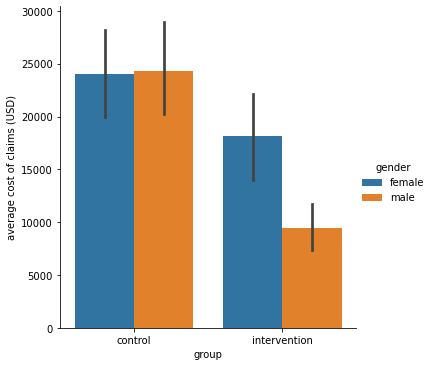

In [9]:
# Interaction effect - plot cost of claims by study group and gender
plt.figure()
ax = sns.catplot(x='group',y='cost_claims',hue = 'gender', kind = 'bar', data=df)
ax.set(xlabel='group', ylabel='average cost of claims (USD)')